In [1]:
!python ptycho/simtrain.py 4

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Traceback (most recent call last):
  File "/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/simtrain.py", line 3, in <module>
    from . import datasets
ImportError: attempted relative import with no known parent package


TODO not fitting the intensity scale might cause problems for larger offset values

check convergence speed for large offsets. might need more epochs

In [121]:
from glob import glob
import numpy as np
import dill
import pandas as pd
import matplotlib.pyplot as plt

prefix = 'overlap_study'
prefixes = glob('{}/*/'.format(prefix))
params_paths = glob('{}/*/params.dill'.format(prefix))
hpaths = glob('{}/*/history.dill'.format(prefix))

def load_dill(path):
    with open(path, 'rb') as f:
        return dill.load(f)

params = [load_dill(p) for p in params_paths]

# histories =  pd.DataFrame({pdict['offset']: load_dill(p)['val_loss'][-1]
#                            for pdict, p in zip(params, hpaths)}).sort_index(axis =1)

# offset_nll = pd.DataFrame([(pdict['offset'],
#                             load_dill(p)['val_loss'][-1],
#                            p)
#      for pdict, p in zip(params, hpaths)
#      if not np.isnan(load_dill(p)['val_loss'][-1])])


from ptycho import params as p
from ptycho import probe
mask = (probe.probe > .01)#np.absolute(probe.probe_mask)#[:, :, 0])
mask = mask.astype(bool)

def overlap_probe(offset):
    res = np.zeros_like(mask)
    for count, i in enumerate([1, -1]):
        if count == 0:
            res ^= (np.roll(mask, (i * offset // 2, 0), axis = (0, 1)))
        else:
            res &= (np.roll(mask, (i * offset // 2, 0), axis = (0, 1)))
    return res

def _offset_to_overlap(offset):
    return overlap_probe(offset).sum() / mask.sum()

def offset_to_overlap(offsets):
    return np.array([_offset_to_overlap(o) for o in offsets])


In [123]:
from ptycho import plotting as pp

(351, 351)

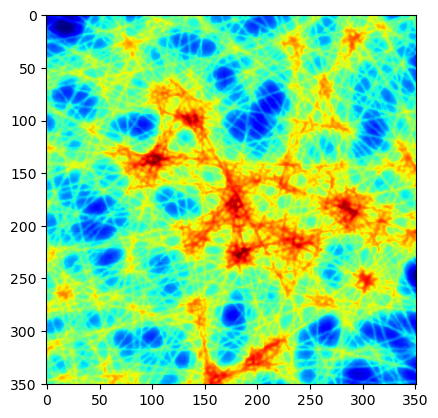

In [28]:
import matplotlib.image as mpimg
img = read_img(recons[0])
imgplot = plt.imshow(img, cmap = 'jet')
img.shape

In [31]:
img2 = read_img(origs[0])

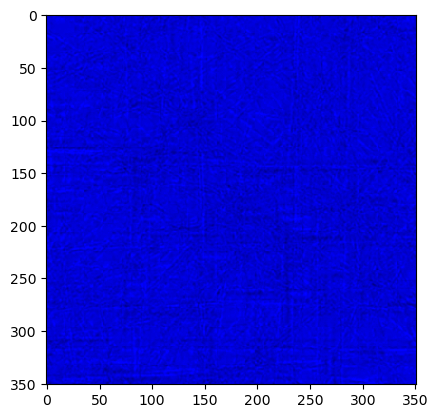

In [37]:
plt.imshow(img2 - img, cmap = 'jet', vmax = img2.max())

In [90]:
from ptycho.misc import *

In [276]:
offset_nll = pd.DataFrame([(pdict['offset'],
                            load_dill(p)['val_loss'][-1],
                           p)
     for pdict, p in zip(params, hpaths)
     if not np.isnan(load_dill(p)['val_loss'][-1])])

offset_nll.columns = ['offset', 'diffraction NLL', 'path']

offset_nll = offset_nll.drop(20) # outlier
offset_paths = offset_nll[['offset', 'path']].set_index('offset')

In [ ]:
mk_impath = lambda fname: offset_paths.path.apply(lambda s: '/'.join(s.split('/')[:-1])
             + fname)

precons = mk_impath('/recon.png').values
porigs = mk_impath('/orig.png').values

def read_img(path):
    img = mpimg.imread(path)
    return colormap2arr(img,cm.jet)

arecons = [read_img(p) for p in precons]

aorigs = [read_img(p) for p in porigs]

mae_mask = (np.array([len(p) for p in arecons]) == np.array([len(p) for p in aorigs]))

arecon = list(np.array(arecons)[mae_mask])
aorig = list(np.array(aorigs)[mae_mask])

mae = lambda target, pred: np.mean(np.absolute(target - pred))

arecon[0] - aorig[0]

maes = [mae(a, b) for a, b in zip(arecon, aorig)]

offset_nll['MAE'] = np.nan

offset_nll.loc[offset_nll.index[mae_mask], 'MAE'] = maes

In [287]:
df = offset_nll[['offset', 'diffraction NLL', 'MAE']].groupby('offset').agg(['mean', 'std'])
df['offset'] = df.index
df['overlap'] = offset_to_overlap(df['offset'])
df['inference time (norm.)'] = (1 / df['offset'])**2
df['inference time (norm.)'] /= df['inference time (norm.)'].max()

df.loc[df.index[-2:], 'overlap']= [-.03, -.06]

# Plots

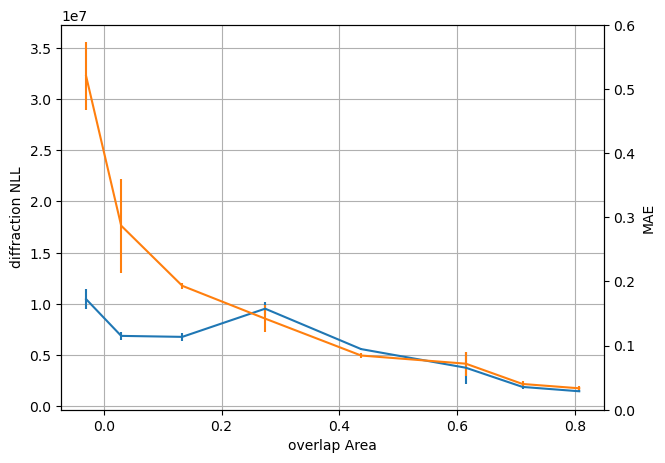

In [318]:
col1, col2 = 'diffraction NLL', 'MAE'
dfgood = df[~df[ycol]['mean'].isna()]

plt.rcParams["figure.figsize"] = (7,5)

scale = 1.4e8

x = dfgood['overlap']
y1 = dfgood[col1]['mean']
y2 = dfgood[col2]['mean'] * scale

y1err=dfgood[col1]['std']
y2err=dfgood[col2]['std'] * scale

fig,ax=plt.subplots()
# ax.plot(x, y1, marker="o")
ax.errorbar(x, y1, yerr= y1err)
plt.xlabel('overlap Area')
ax.set_ylabel(col1)
plt.grid()


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(x, y2,color="blue",marker="o")
ax.errorbar(x, y2, yerr= y2err)
ax2.set_ylabel(col2)
ax2.set_ylim((0, .6))
plt.show()

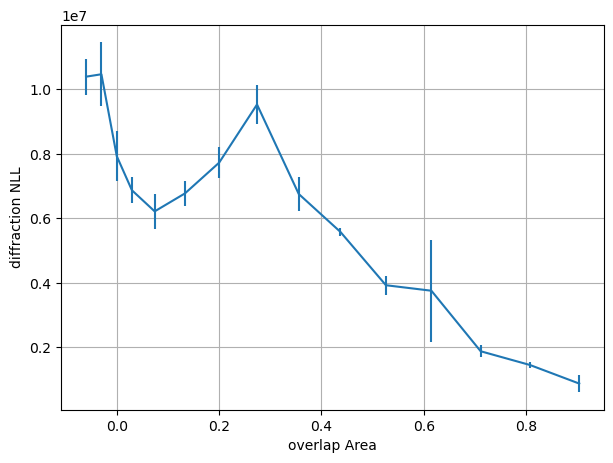

In [322]:
plt.rcParams["figure.figsize"] = (7,5)

plt.errorbar(df['overlap'], df['diffraction NLL']['mean'], yerr=df['diffraction NLL']['std'])
plt.xlabel('overlap Area')
plt.ylabel('diffraction NLL')
plt.grid()

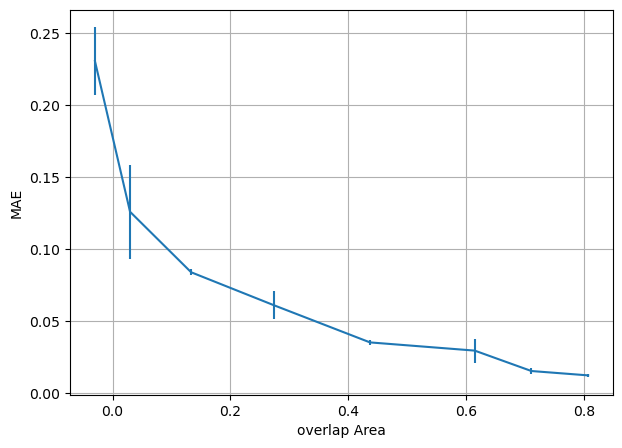

In [319]:
ycol = 'MAE'
dfgood = df[~df[ycol]['mean'].isna()]

plt.rcParams["figure.figsize"] = (7,5)

plt.errorbar(dfgood['overlap'], dfgood[ycol]['mean'], yerr=dfgood[ycol]['std'])
plt.xlabel('overlap Area')
plt.ylabel(ycol)
plt.grid()

In [60]:
_offset_to_overlap(14)

0.35555555555555557

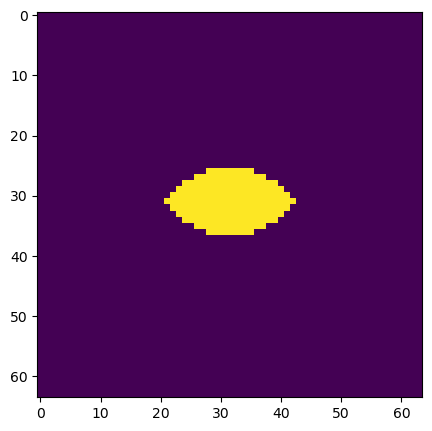

In [69]:
plt.imshow(overlap_probe(15))

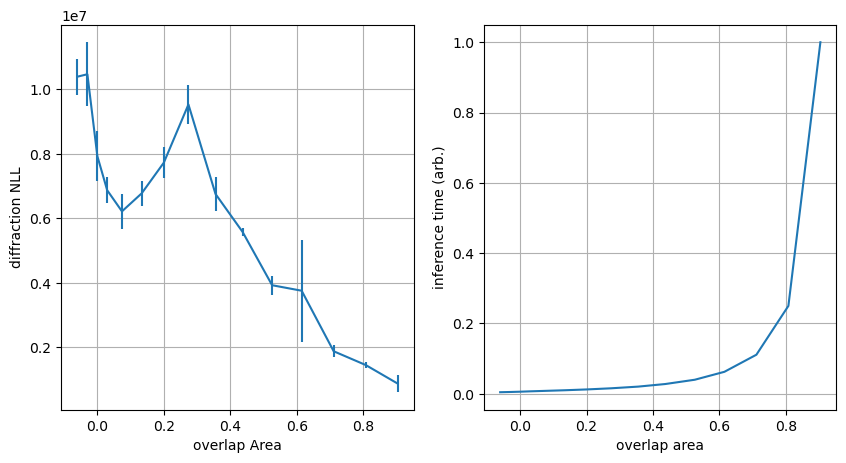

In [62]:
plt.rcParams["figure.figsize"] = (10,5)

a, b = 1, 2
plt.subplot(a, b, 1)
plt.errorbar(df['overlap'], df['diffraction NLL']['mean'], yerr=df['diffraction NLL']['std'])
plt.grid()
plt.xlabel('overlap Area')
plt.ylabel('diffraction NLL')

plt.subplot(a, b, 2)
plt.plot(df['overlap'], df['inference time (norm.)'])
plt.xlabel('overlap area')
plt.ylabel('inference time (arb.)')
plt.grid()

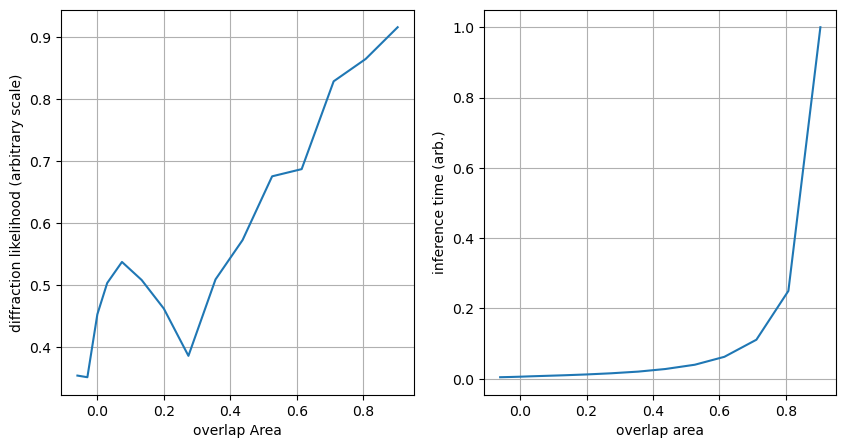

In [63]:
plt.rcParams["figure.figsize"] = (10,5)

a, b = 1, 2
plt.subplot(a, b, 1)
plt.plot(df['overlap'], np.exp(-1e-7 * df['diffraction NLL']['mean']))
plt.xlabel('overlap Area')
plt.ylabel('diffraction likelihood (arbitrary scale)')
plt.grid()

plt.subplot(a, b, 2)
plt.plot(df['overlap'], df['inference time (norm.)'])
plt.xlabel('overlap area')
plt.ylabel('inference time (arb.)')
plt.grid()

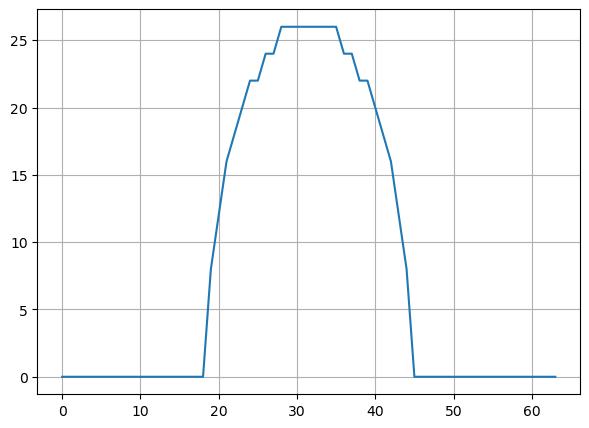

In [66]:
plt.plot(mask.sum(axis = 0))
plt.grid()

In [75]:
# import numpy as np
# import matplotlib.pyplot as plt


# class IndexTracker:
#     def __init__(self, ax, X):
#         self.index = 0
#         self.X = X
#         self.ax = ax
#         self.im = ax.imshow(self.X[:, :, self.index])
#         self.update()

#     def on_scroll(self, event):
#         print(event.button, event.step)
#         increment = 1 if event.button == 'up' else -1
#         max_index = self.X.shape[-1] - 1
#         self.index = np.clip(self.index + increment, 0, max_index)
#         self.update()

#     def update(self):
#         self.im.set_data(self.X[:, :, self.index])
#         self.ax.set_title(
#             f'Use scroll wheel to navigate\nindex {self.index}')
#         self.im.axes.figure.canvas.draw()


# x, y, z = np.ogrid[-10:10:100j, -10:10:100j, 1:10:20j]
# X = np.sin(x * y * z) / (x * y * z)

# fig, ax = plt.subplots()
# # create an IndexTracker and make sure it lives during the whole
# # lifetime of the figure by assigning it to a variable
# tracker = IndexTracker(ax, X)

# fig.canvas.mpl_connect('scroll_event', tracker.on_scroll)
# plt.show()

In [6]:
from ptycho import params as p
p.cfg['offset'] = 24
p.cfg['nepochs'] = 1
#p.cfg['output_prefix'] = 'outputs'
p.cfg['output_prefix'] = 'tmp'
p.cfg

{'N': 64,
 'offset': 24,
 'gridsize': 2,
 'bigoffset': 4,
 'batch_size': 16,
 'nepochs': 1,
 'h': 64,
 'w': 64,
 'intensity_scale.trainable': False,
 'probe.trainable': False,
 'n_filters_scale': 2,
 'output_prefix': 'tmp'}

In [ ]:
from ptycho.simtrain import *

phase min: -0.06493041 phase max: 0.06411664


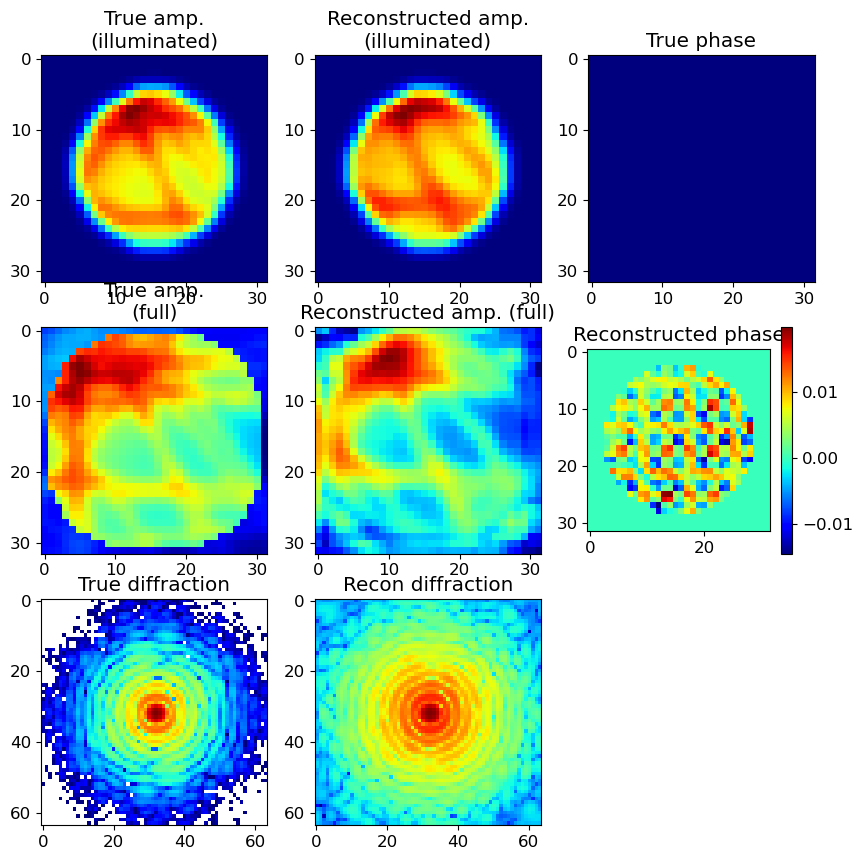

In [5]:
# Offset 4
from ptycho import evaluation
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe.probe, 0)

phase min: -0.041521035 phase max: 0.054786596


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


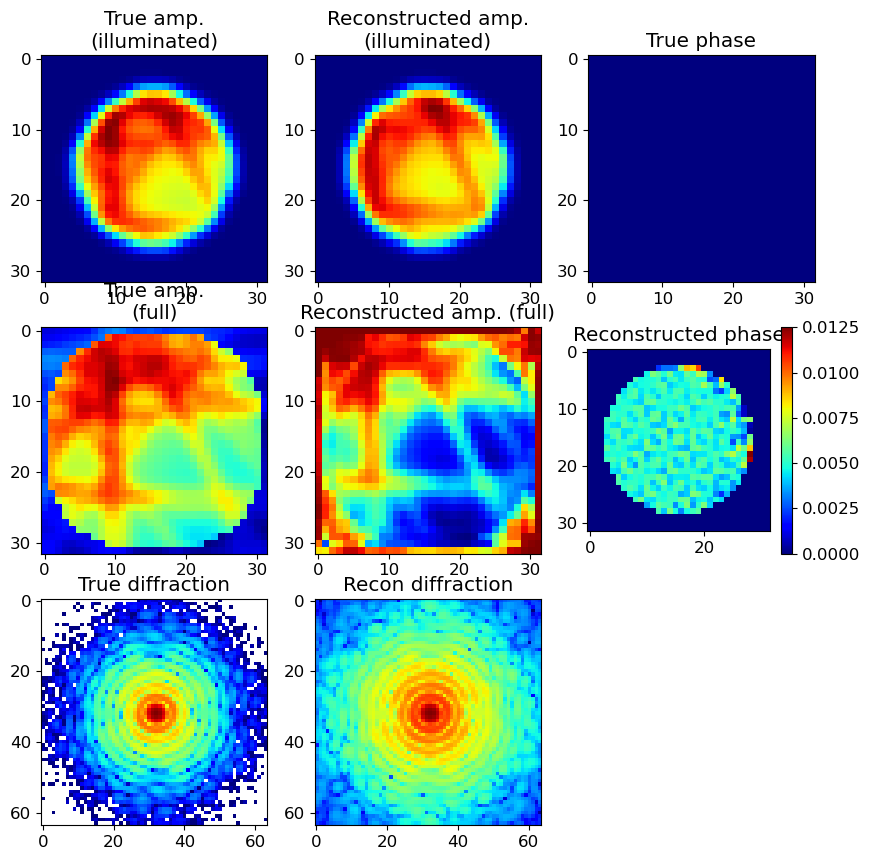

In [5]:
# Offset 4
from ptycho import evaluation
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

phase min: -0.087284155 phase max: 0.07144611


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


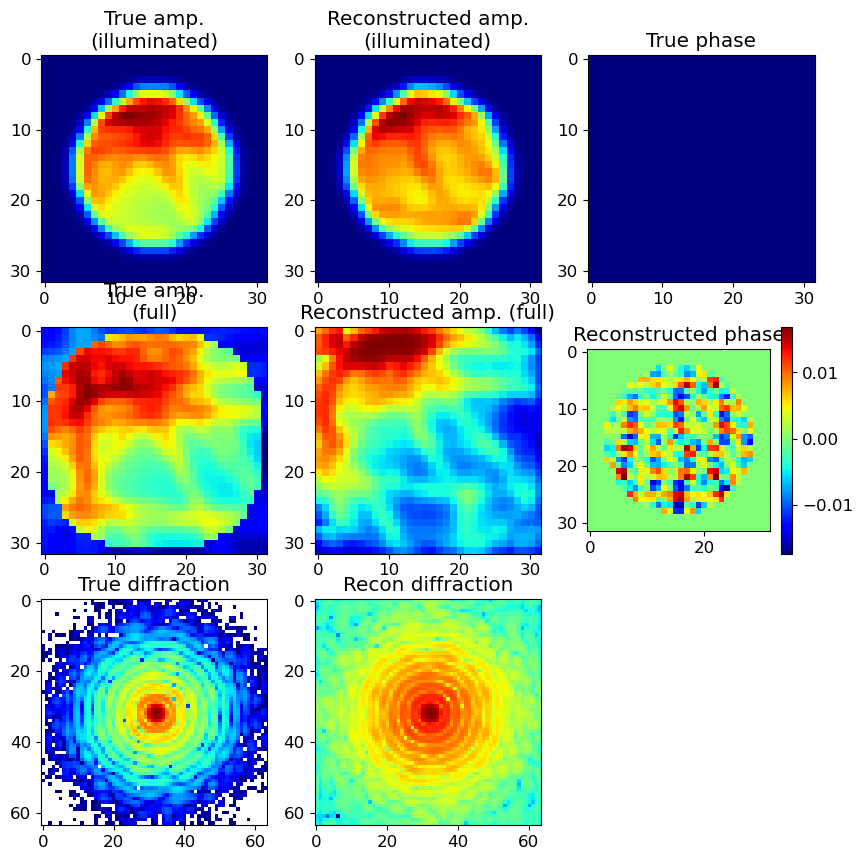

In [6]:
from ptycho import evaluation
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

In [5]:
YY_I_test_full[0, clipleft: -clipright, clipleft: -clipright].shape

(317, 317, 1)

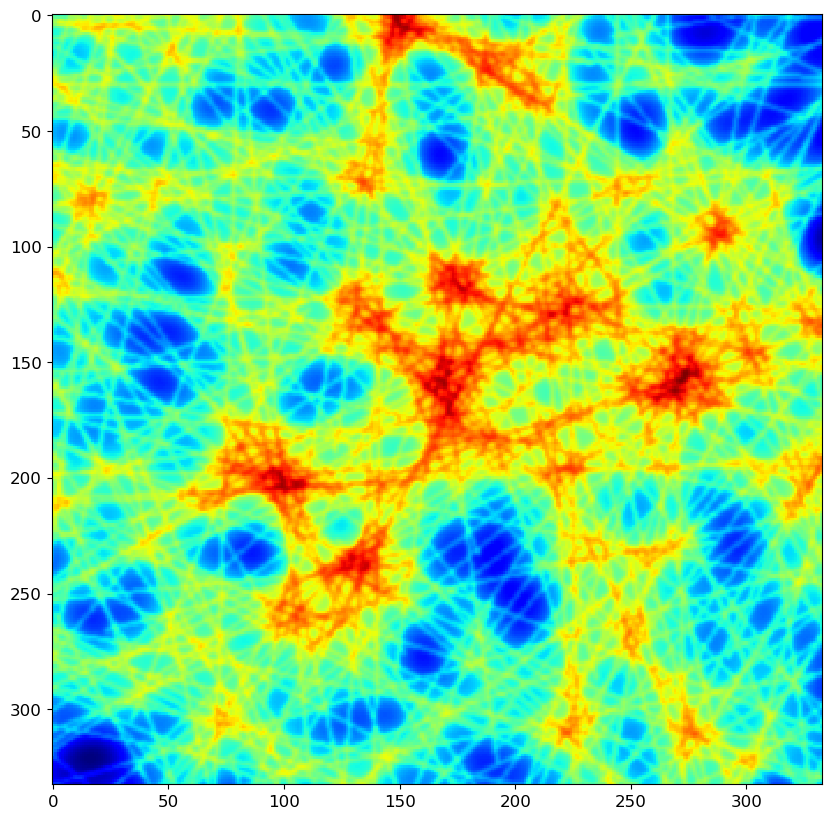

In [6]:
bordersize = N // 2 - bigoffset // 4
clipsize = (bordersize + ((gridsize - 1) * offset) // 2)

plt.imshow(YY_I_test_full[0, clipleft: -clipright, clipleft: -clipright], interpolation = 'none',
          cmap = 'jet')
vmin = np.min(YY_I_test_full[0, clipleft: -clipright, clipleft: -clipright])
vmax = np.max(YY_I_test_full[0, clipleft: -clipright, clipleft: -clipright])

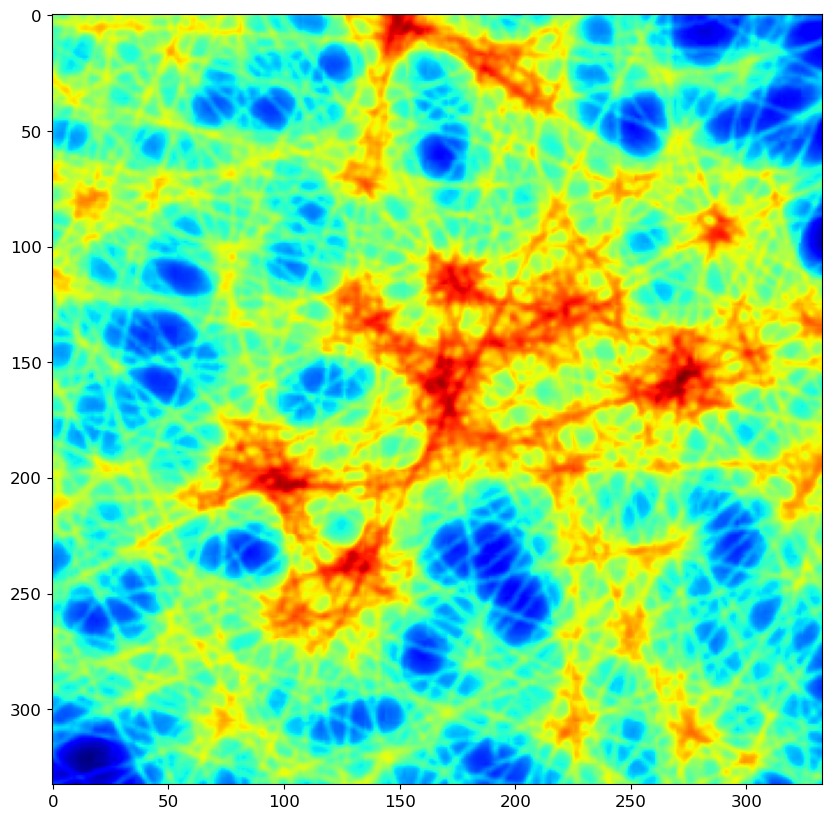

In [7]:
# offset 4
import matplotlib.pyplot as plt
plt.imshow(stitched[0], cmap = 'jet')

In [5]:
from ptycho import evaluation

Offset 8

phase min: -0.037509844 phase max: 0.09267076


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


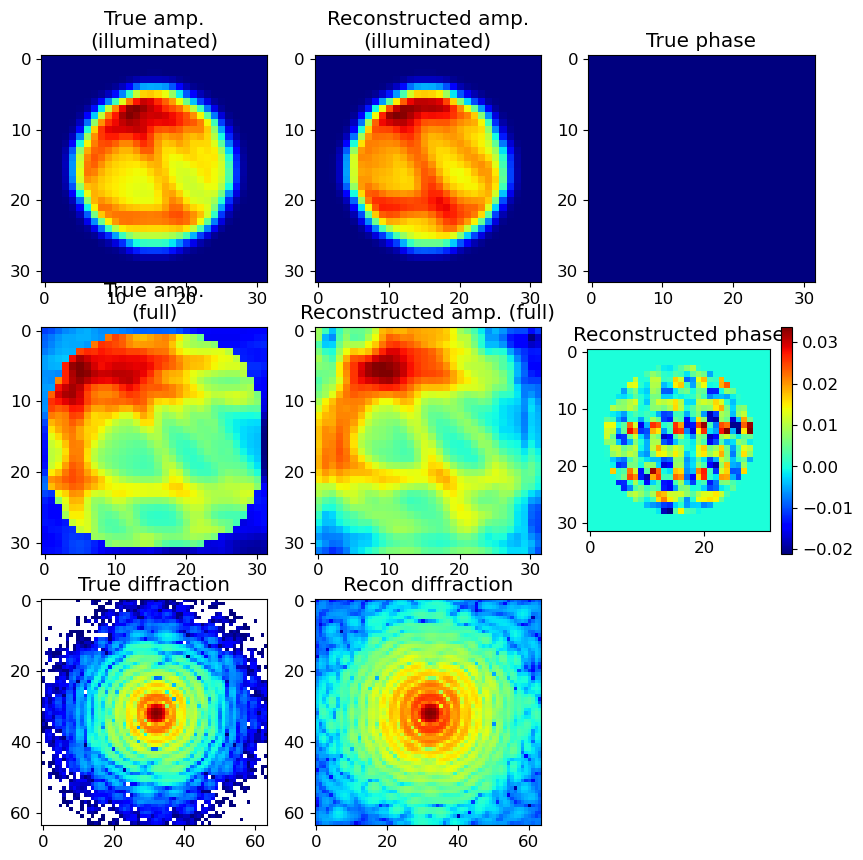

In [6]:
#plt_metrics()
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

Offset 10

phase min: -0.1137828 phase max: 0.1211003


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


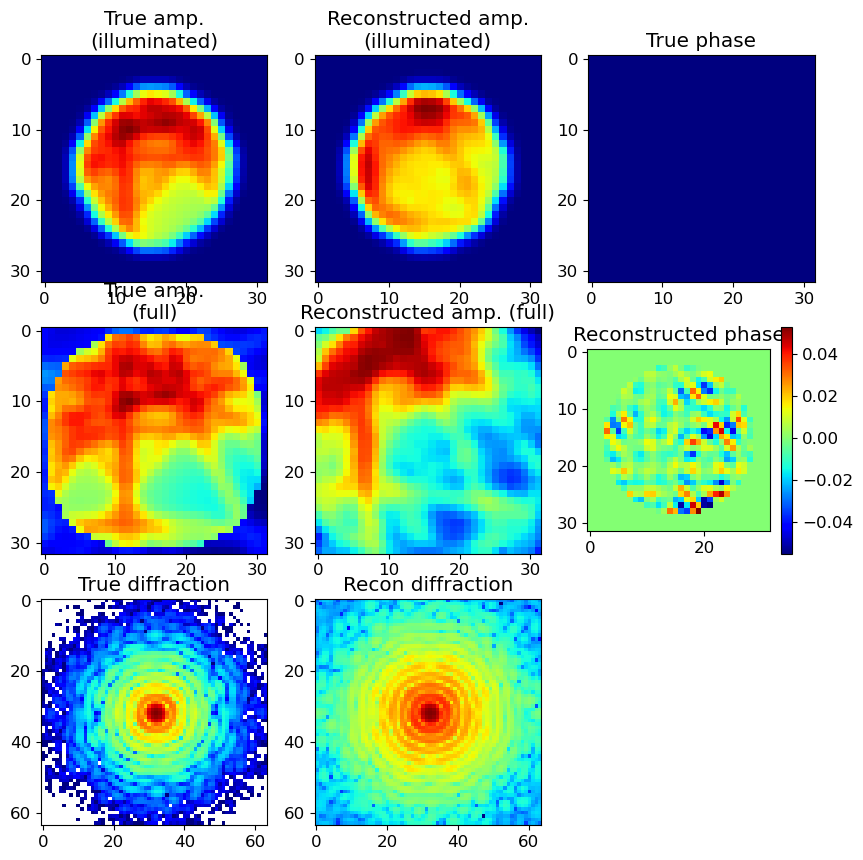

In [6]:
from ptycho import evaluation
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

Offset 12

phase min: -0.13856006 phase max: 0.14993173


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


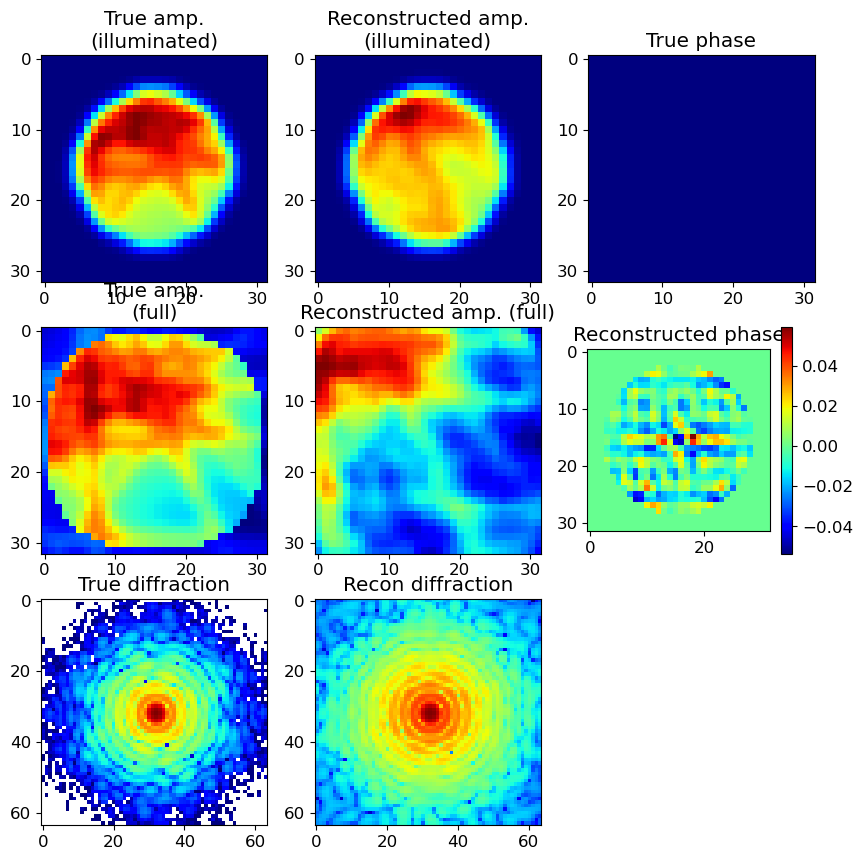

In [6]:
from ptycho import evaluation
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

phase min: -0.64635056 phase max: 0.78957057


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


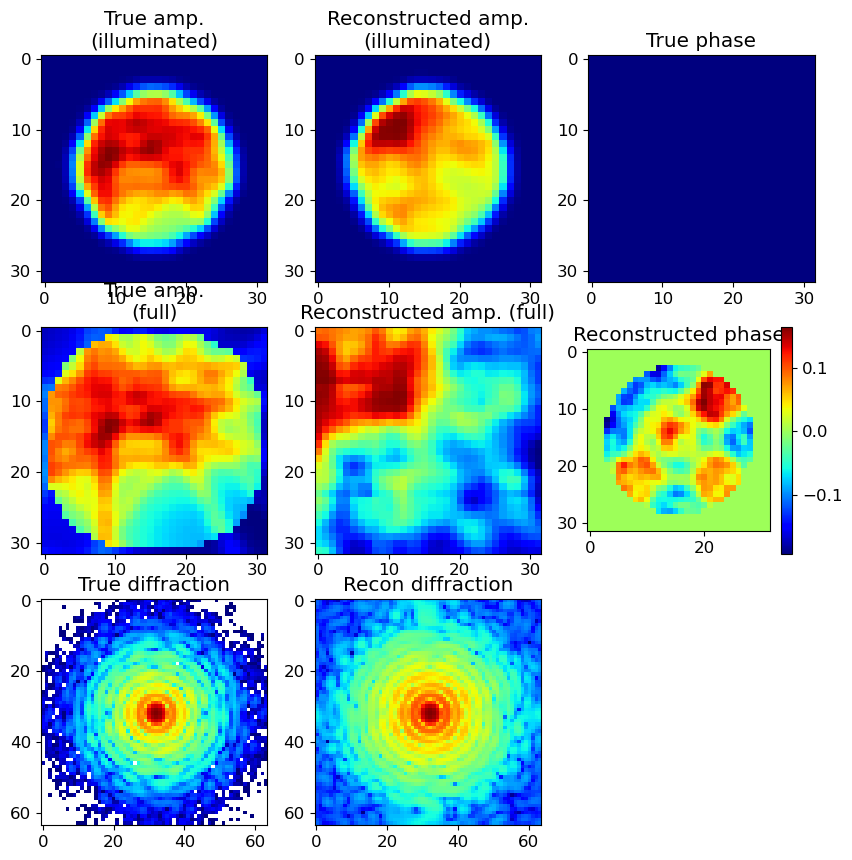

In [3]:
# offset 16
from ptycho import evaluation
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

phase min: -1.0272716 phase max: 1.00734


/home/ollie/Documents/scratch/ptycho2/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


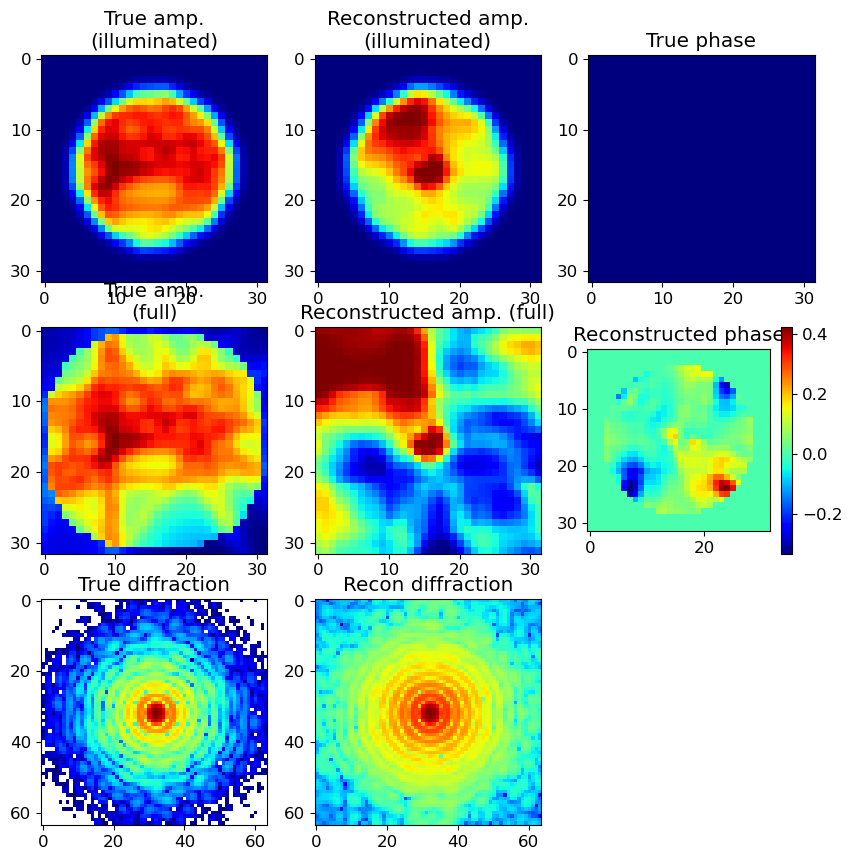

In [7]:
from ptycho import evaluation
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe.probe, 0)

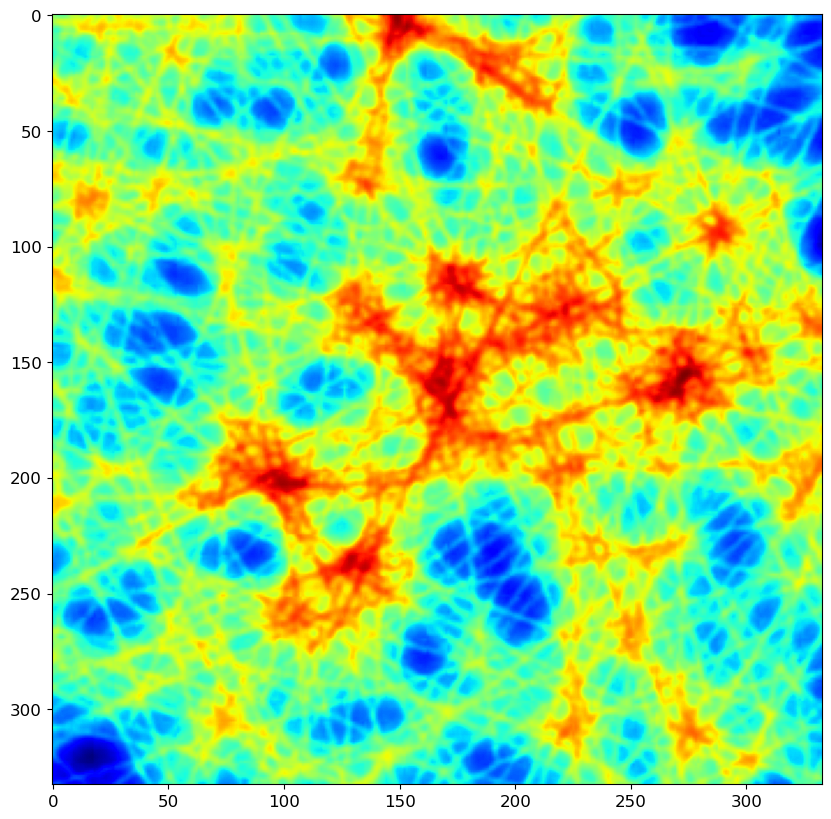

In [7]:
# offset 4
import matplotlib.pyplot as plt
plt.imshow(stitched[0], cmap = 'jet')

In [113]:
df

offset  diffraction NLL   overlap  inference time (norm.)
0       2       841460.125  0.842365                1.000000
1       4      1512689.625  0.684729                0.250000
2       6      1914242.750  0.527094                0.111111
3       8      2895401.500  0.369458                0.062500
4      10      4455027.000  0.221675                0.040000
5      12      5045445.000  0.073892                0.027778
6      16      9268222.000 -0.211823                0.015625

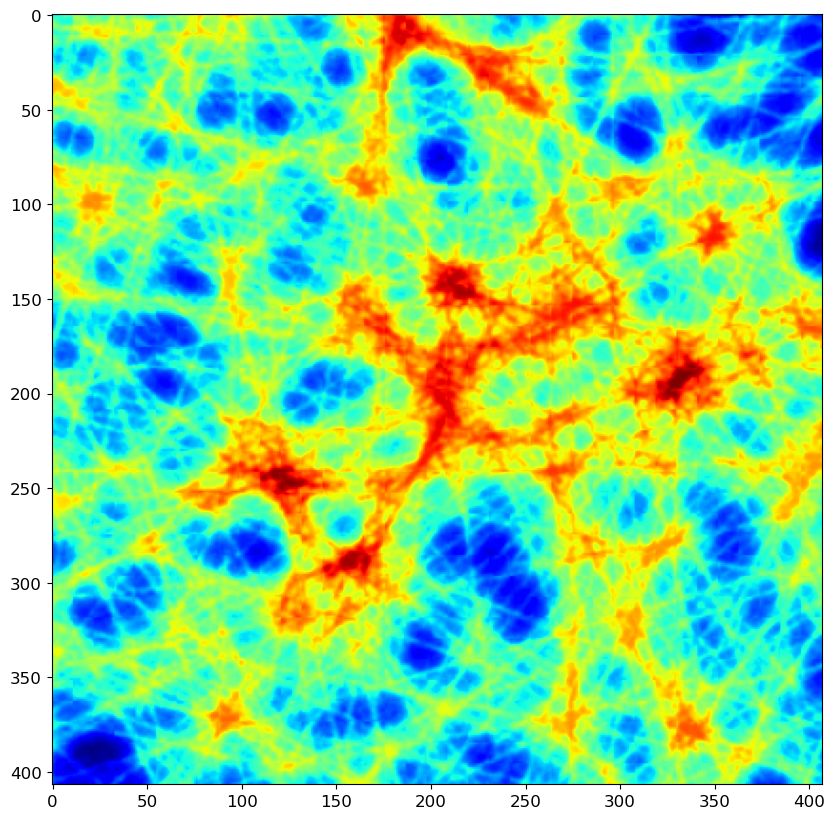

In [7]:
# offset 12
import matplotlib.pyplot as plt
plt.imshow(stitched[0], cmap = 'jet')

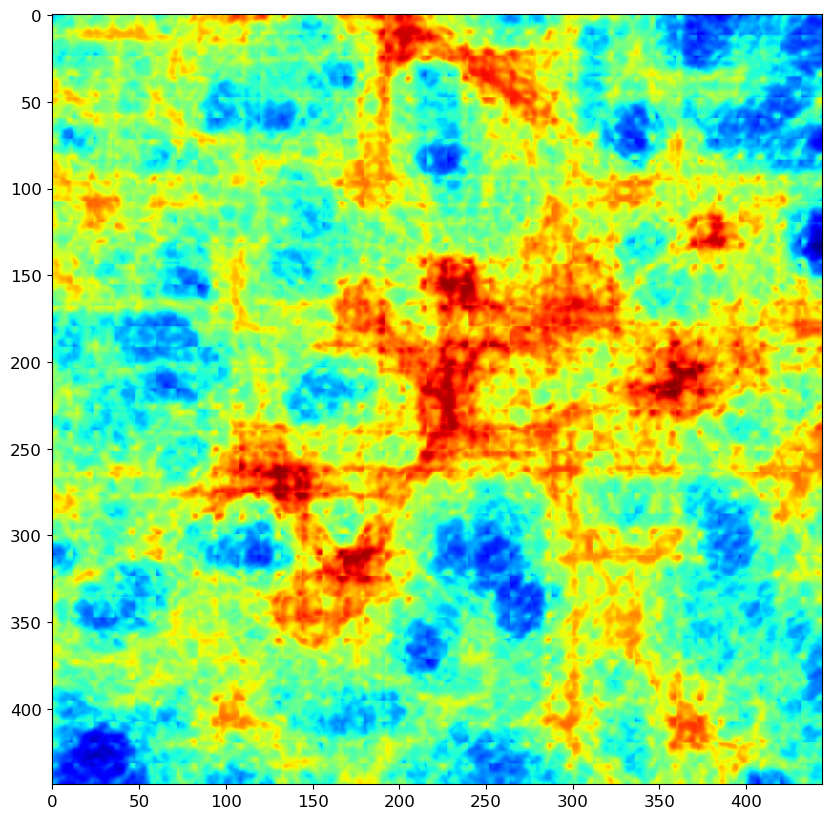

In [4]:
# offset 16
import matplotlib.pyplot as plt
plt.imshow(stitched[0], cmap = 'jet')

In [10]:
YY_I_test_full.shape

(3, 552, 552, 1)

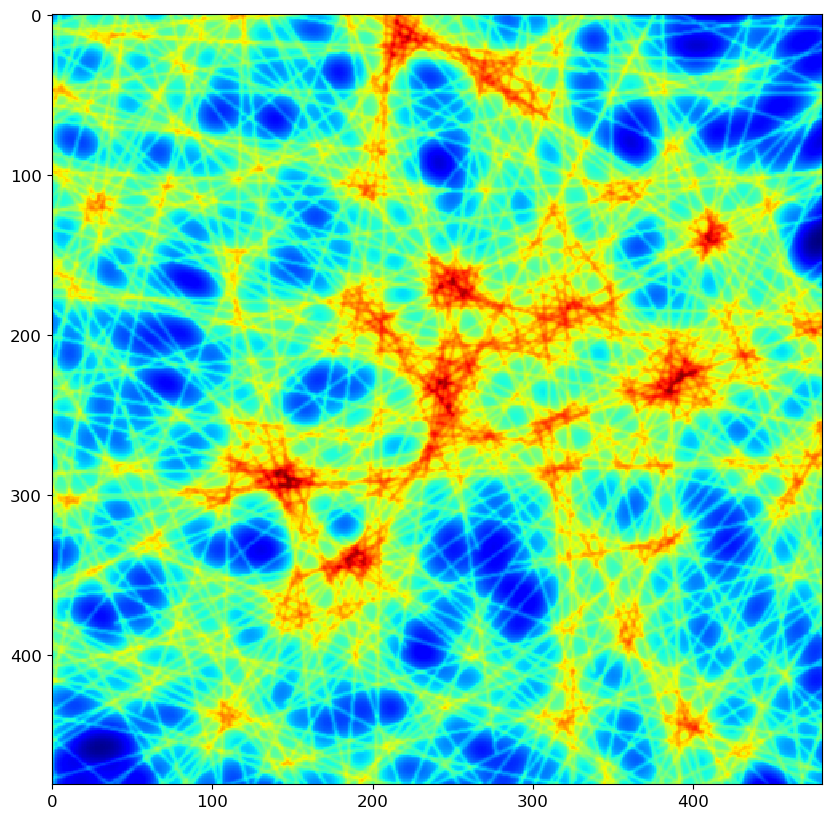

In [9]:
bordersize = N // 2 - bigoffset // 4
clipsize = (bordersize + ((gridsize - 1) * offset) // 2)

plt.imshow(YY_I_test_full[0, clipleft: -clipright, clipleft: -clipright], interpolation = 'none',
          cmap = 'jet')
vmin = np.min(YY_I_test_full[0, clipleft: -clipright, clipleft: -clipright])
vmax = np.max(YY_I_test_full[0, clipleft: -clipright, clipleft: -clipright])

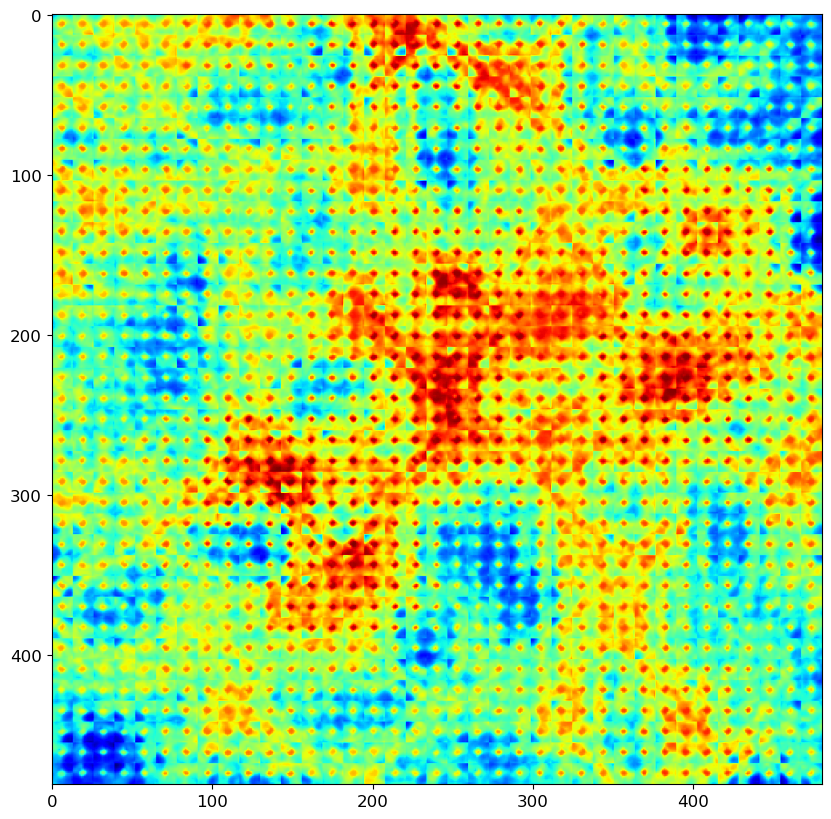

In [8]:
# offset 20
import matplotlib.pyplot as plt
plt.imshow(stitched[0], cmap = 'jet')

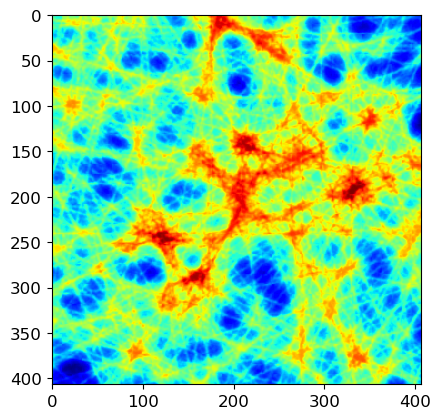

In [5]:
import matplotlib.pyplot as plt
plt.imshow(stitched[0], cmap = 'jet')